In [1]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os

import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from pyswarms.single.global_best import GlobalBestPSO

Número de filas y columnas: (2557, 1) 

Tipo de datos:
 Load    int64
dtype: object 

Head:
                   Load
Date                  
2015-01-01  5686686080
2015-01-02  6752007030
2015-01-03  6605796020
2015-01-04  6273091530
2015-01-05  6760770300 



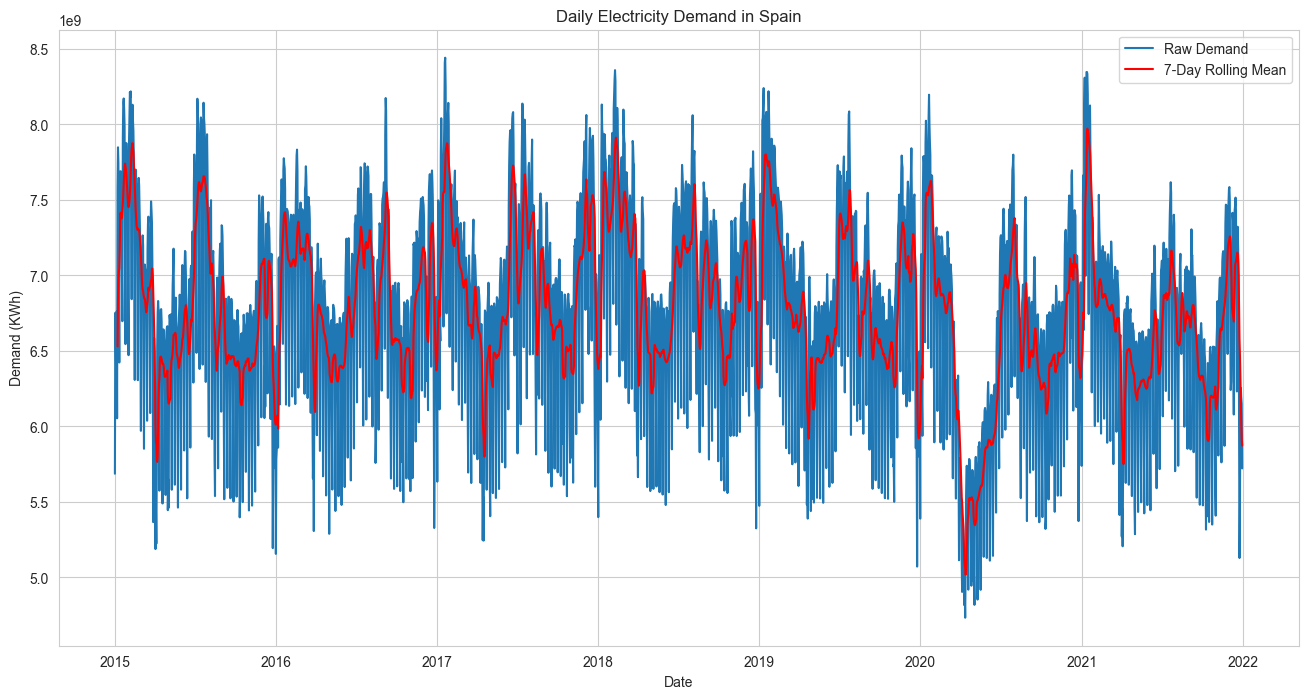

In [2]:
# Load dataset
path = os.getcwd()
fichero_DemandaDiaria = os.path.join(path, 'DemandaDiaria_KWh_2015-2021.csv')

# Read the data
data = pd.read_csv(fichero_DemandaDiaria, sep=";")
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Check the data
print("Número de filas y columnas:", data.shape, "\n")
print("Tipo de datos:\n", data.dtypes, "\n")
print("Head:\n", data.head(), "\n")

# Graph the data
sns.set_style("whitegrid")
rolling_mean = data['Load'].rolling(window=7).mean()
plt.figure(figsize=(16, 8))
plt.title('Daily Electricity Demand in Spain')
plt.xlabel('Date')
plt.ylabel('Demand (KWh)')
plt.plot(data.index, data['Load'], label='Raw Demand')
plt.plot(data.index, rolling_mean, color='red', label='7-Day Rolling Mean')
plt.legend(loc='best')
plt.show()

In [3]:
# Standardize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Load'].values.reshape(-1, 1))

# Split the data into training and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size, :]
test_data = scaled_data[train_size:, :]

# Create sequences of length 'sequence_length' to use as input data
def create_sequences(dataset, sequence_length_scope):
    X, y = [], []
    # Iterate over the dataset and create sequences of length 'sequence_length'
    for i in range(len(dataset) - sequence_length_scope):
        # Add a sequence of length 'sequence_length' to X
        X.append(dataset[i:i + sequence_length_scope, 0])
        # Add the next data point after each sequence of length 'sequence_length' to y
        y.append(dataset[i + sequence_length_scope, 0])
    # Convert list to array
    return np.array(X), np.array(y)

sequence_length = 10  # Length of the sequence for each input point
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Check the shape of the training sequences
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2035, 10)
y_train shape: (2035,)
X_test shape: (502, 10)
y_test shape: (502,)


In [4]:
# Definir la función objetivo para la optimización
def objective_function(params):
    return svr_cost(params)

# Definir la función de costo para la SVR
def svr_cost(params):
    n_particles = params.shape[0]
    costs = np.zeros(n_particles)
    for i in range(n_particles):
        if len(params[i]) == 1:
            C = float(params[i][0])  # Convertir a flotante
            if C <= 0.0:
                C = 0.1  # Valor predeterminado si C es no válido
            model = SVR(kernel='rbf', C=C)
        elif len(params[i]) == 2:
            C, gamma = map(float, params[i])  # Convertir a flotantes
            if C <= 0.0:
                C = 0.1  # Valor predeterminado si C es no válido
            model = SVR(kernel='rbf', C=C, gamma=gamma)
        else:
            raise ValueError("Invalid number of parameters")
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
        costs[i] = rmse
    
    return costs

In [5]:
# Optimizar 'C'
# No todos los valores de C son válidos
bounds = ( [0.001], [10] )
optimizer_c = GlobalBestPSO(n_particles=10, dimensions=1, options={"c1": 0.5, "c2": 0.3, "w": 0.9}, bounds=bounds)
best_cost_c, best_params_c = optimizer_c.optimize(objective_function, iters=50)

# Obtener el valor óptimo de 'C'
if isinstance(best_params_c, (list, np.ndarray)):
    C_opt = best_params_c[0]
else:
    C_opt = best_params_c


# Optimizar 'gamma'
bounds = ( np.array( [0.001, 0.01]), np.array( [10.0, 10.0] ) )
# gamma_options = ('scale', 'auto')
optimizer_gamma = GlobalBestPSO(n_particles=10, dimensions=2, options={"c1": 0.5, "c2": 0.3, "w": 0.9}, bounds= bounds)
best_cost_gamma, best_params_gamma = optimizer_gamma.optimize(objective_function, iters=50)

# Obtener el valor óptimo de 'gamma'
C_opt_gamma = best_params_gamma[0]
gamma_opt = best_params_gamma[1]


2023-09-05 10:23:41,382 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=2.58e+8
2023-09-05 10:24:10,612 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 258484742.51981655, best pos: [0.26224815]
2023-09-05 10:24:10,622 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|█████████████████████|50/50, best_cost=2.47e+8
2023-09-05 10:24:41,426 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 247379582.28136504, best pos: [4.84323726 0.5284065 ]


In [6]:
# Crear y entrenar el modelo con los mejores hiperparámetros encontrados
best_model = SVR(kernel='rbf', C=C_opt_gamma, gamma=gamma_opt)
best_model.fit(X_train, y_train)

SVR(C=4.84323725663481, gamma=0.5284065010237597)

In [10]:
# Invert the normalization for y_pred and y_test
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test_original, y_pred_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))

# Calculate MRAE (Mean Absolute Percentage Error)
mrae = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100

# Print metrics
print('MAE: {:,.2f}'.format(mae))
print('RMSE: {:,.2f}'.format(rmse))
print('MRAE: {:,.2f} %'.format(mrae))

MAE: 177,178,706.23
RMSE: 247,379,582.28
MRAE: 2.72 %


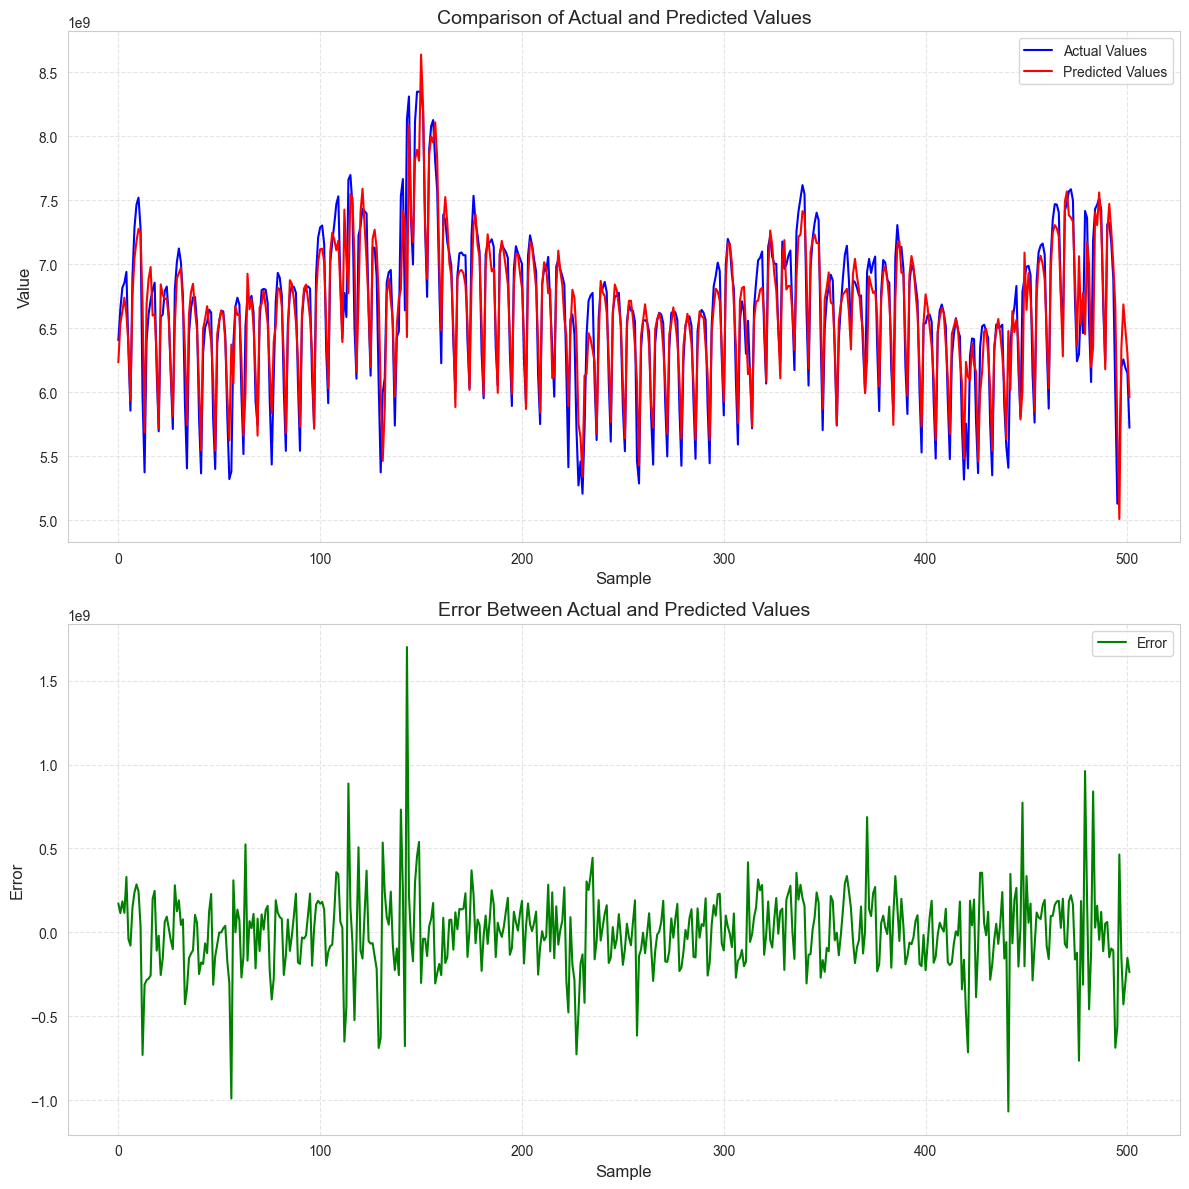

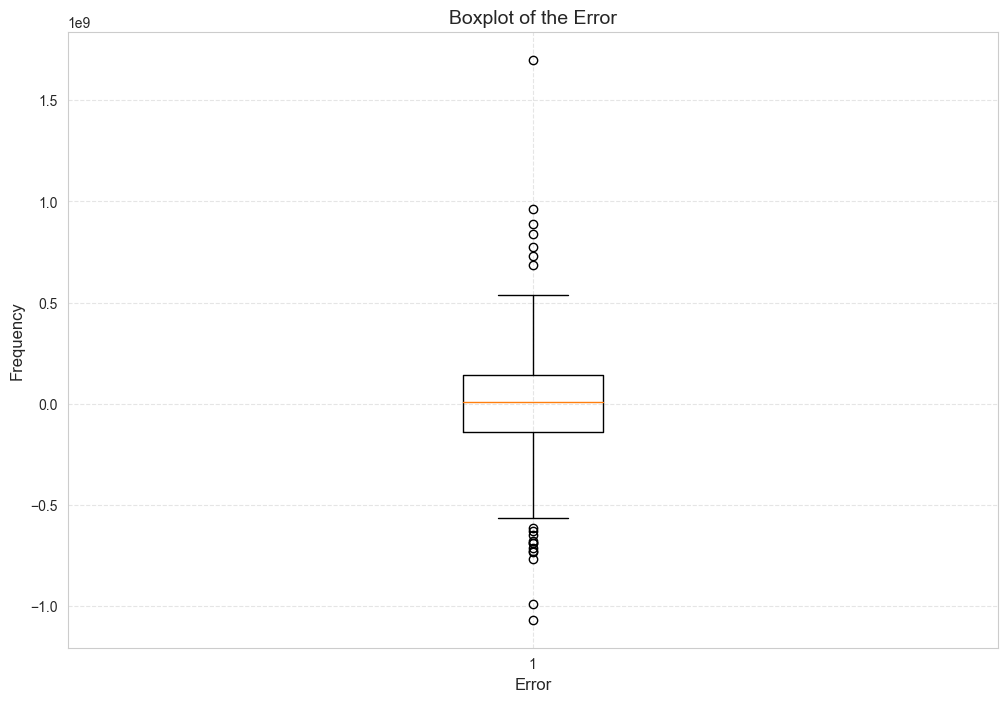

In [11]:
# Calculate the error between actual and predicted values
error = y_test_original - y_pred_original

# Create a figure and a set of subplots (2 subplots)
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot the actual vs predicted values in the first subplot
axes[0].plot(y_test_original, label='Actual Values', color='blue')
axes[0].plot(y_pred_original, label='Predicted Values', color='red')
axes[0].set_xlabel('Sample', fontsize=12)
axes[0].set_ylabel('Value', fontsize=12)
axes[0].set_title('Comparison of Actual and Predicted Values', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.5)

# Plot the error in the second subplot
axes[1].plot(error, label='Error', color='green')
axes[1].set_xlabel('Sample', fontsize=12)
axes[1].set_ylabel('Error', fontsize=12)
axes[1].set_title('Error Between Actual and Predicted Values', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.5)

# Show the plots
plt.tight_layout()
plt.show()

# Boxplot of the error
plt.figure(figsize=(12, 8))
plt.boxplot(error)
plt.xlabel('Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Boxplot of the Error', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()